# Homework #5 - Ravi Raghavan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Theoretical Calculations of Gradient and Hessian

$f(x) = - \sum_{i=1}^{m} \log{(1 - a_i^Tx)} - \sum_{i=1}^{n} \log{(1 - x_i^2)}$

$x \in \mathbb{R}^n$ and $dom f = \{ x | a_i^Tx < 1, i = 1, 2, ..., m, |x_i| < 1, i = 1, 2, ..., n\}$





$\frac{\partial{f}}{\partial{x_j}} = - (\sum_{i=1}^{m} (\frac{1}{1 - a_i^Tx}) (-a_{ij})) - \frac{1}{(1 - x_j^2)} (-2x_j)$

$\frac{\partial{f}}{\partial{x_j}} =  \sum_{i=1}^{m} (\frac{a_{ij}}{1 - a_i^Tx}) + \frac{2x_j}{(1 - x_j^2)}$


$\frac{\partial{f}}{\partial{x_k} \partial{x_j}}$: 

Case where $j = k$:

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} a_{ij} (\frac{-1}{(1 - a_i^Tx)^2}) (-a_{ik}) + \frac{2(1 - x_j^2) - 2x_j(-2x_j)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$


Case where $j \neq k$: 

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})$





## Programmatic Implementations of Descent Methods

In [2]:
def gradient_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        
        #Purely for my curiosity, I wanted to see the condition number of the Hessian
        # H = hessian(A, x) #compute hessian
        print(f"Iteration: {iter + 1}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}")
        
        #if we have satisfied our convergence criteria, break from loop
        if np.linalg.norm(grad) <= eta:
            break
        
        descent_direction = -1 * grad #our descent direction is the negative gradient
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [3]:
#H: Hessian
#g: gradient
#Solve the system H @ x_nt = -g
def solve_newton_system(H: np.ndarray, g: np.ndarray):
    L = np.linalg.cholesky(H) #compute Cholesky Decomposition of H
    n = L.shape[0]
    
    #forward substitution to solve Lw = b where b = -g
    w = np.zeros(shape = g.shape)
    b = -1 * g
    
    w[0, 0] = b[0, 0] / L[0, 0]
    for idx in range(1, n):
        w[idx, 0] = (b[idx, 0] - np.dot(L[idx, :idx].flatten(), w[:idx, 0].flatten())) / L[idx, idx]
    
    #backward substitution to solve L^T @ x_nt = w
    L_transpose = L.T
    x_nt = np.zeros(shape = g.shape)
    
    x_nt[n - 1, 0] = w[n - 1, 0] / L_transpose[n - 1, n - 1]
    for idx in range(n - 2, -1, -1):
        x_nt[idx, 0] = (w[idx, 0] - np.dot(L_transpose[idx, -1:idx:-1].flatten(), x_nt[-1:idx:-1, 0].flatten())) / L_transpose[idx, idx]
    
    lambda_squared = np.linalg.norm(w) ** 2
    return x_nt, lambda_squared

In [4]:
def newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = hessian(A, x) #compute hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad)
        print(f"Iteration: {iter + 1}, Current Function Value(Beginning of Iteration): {fx}, Newton Parameter: {newton_parameter}")
        
        descent_direction = newton_direction #our descent direction is the newton direction
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [5]:
def reuse_newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta, N):
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #Store Hessians
    hessians = []
    H = hessian(A, x) #compute hessian
    hessians.append(H)
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        
        #Get Hessian
        if (iter > 0) and (iter % N == 0):
            H = hessian(A, x)
            hessians.append(H)
        else:
            H = hessians[-1]
        
        newton_direction, newton_parameter = solve_newton_system(H, grad)
        print(f"Iteration: {iter + 1}, Current Function Value(Beginning of Iteration): {fx}, Newton Parameter: {newton_parameter}")
        
        descent_direction = newton_direction #our descent direction is the newton direction
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [6]:
def diagonal_newton_descent(f, gradient, diagonal_hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = diagonal_hessian(A, x) #compute diagonal hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad)
        print(f"Iteration: {iter + 1}, Current Function Value(Beginning of Iteration): {fx}, Newton Parameter: {newton_parameter}")
        
        descent_direction = newton_direction #our descent direction is the newton direction
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [7]:
#Given A and x, check to see if x is within the domain of f
def domain_check(A: np.ndarray, x: np.ndarray):
    B = A @ x
    max_B = np.max(B)
    max_x = np.max(np.abs(x))
    return max_B < 1 and max_x < 1

def f(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    B = A @ x
    log_comp_B = np.log(1 - B)
    log_x = np.log(1 - (np.square(x)))
    return (-1 * np.sum(log_comp_B)) - np.sum(log_x)

#each a_i is a row of A
def f_gradient(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    gradient_vector = np.zeros(shape = x.shape)
    
    for j in range(x.shape[0]):
        cum_total = 0
        for i in range(A.shape[0]):
            cum_total += A[i, j] / (1 - B[i, 0])
        gradient_vector[j, 0] = cum_total + ((2 * x[j, 0]) / (1 - (x[j, 0] ** 2)))
    
    return gradient_vector   

#Compute Hessian
def f_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    hessian_matrix = np.zeros(shape = (x.shape[0], x.shape[0]))

    for k in range(x.shape[0]):
        for j in range(x.shape[0]):
            #Compute d^2f / dxk dxj
            cum_total = 0
            for i in range(A.shape[0]):
                cum_total += (A[i, j] * A[i, k]) / ((1 - B[i, 0]) ** 2)
            
            if j == k:
                cum_total += ((2 * (1 + (x[j, 0] ** 2))) / ((1 - (x[j, 0] ** 2)) ** 2))
            
            hessian_matrix[k, j] = cum_total
    
    return hessian_matrix

def f_diagonal_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    hessian_matrix = np.zeros(shape = (x.shape[0], x.shape[0]))

    for k in range(x.shape[0]):
        j = k
        #Compute d^2f / dxk dxj
        cum_total = 0
        for i in range(A.shape[0]):
            cum_total += (A[i, j] * A[i, k]) / ((1 - B[i, 0]) ** 2)
        
        if j == k:
            cum_total += ((2 * (1 + (x[j, 0] ** 2))) / ((1 - (x[j, 0] ** 2)) ** 2))
        
        hessian_matrix[k, j] = cum_total
    
    return hessian_matrix

def f_backtracking_algorithm(A: np.ndarray, x: np.ndarray, delta_x: np.ndarray, alpha, beta):
    t = 1
    #First we must multiply t by Beta until we get within the domain
    while not domain_check(A, x):
        t = beta * t
    
    while (f(A, x + (t * delta_x))) > (f(A, x) + (alpha * t * (f_gradient(A, x).T @ delta_x))):
        t = beta * t
        
    return t 

## 9.30 (a): Gradient Descent Method with Backtracking Line Search

### Experiment #1: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.1$ 

In [8]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.1
eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [9]:
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = gradient_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 137.6036924927425
Iteration: 2, Current Function Value(Beginning of Iteration): -16.401208696404982, Norm of Gradient: 104.30434203439768
Iteration: 3, Current Function Value(Beginning of Iteration): -26.360557186578617, Norm of Gradient: 88.11261268218546
Iteration: 4, Current Function Value(Beginning of Iteration): -33.67914967216268, Norm of Gradient: 78.69176035506953
Iteration: 5, Current Function Value(Beginning of Iteration): -39.605297441701055, Norm of Gradient: 72.2137430560397
Iteration: 6, Current Function Value(Beginning of Iteration): -76.04749614087166, Norm of Gradient: 65.73861177812641
Iteration: 7, Current Function Value(Beginning of Iteration): -78.73201409279098, Norm of Gradient: 46.620188211622164
Iteration: 8, Current Function Value(Beginning of Iteration): -80.66392612020331, Norm of Gradient: 41.20471900791452
Iteration: 9, Current Function Value(Beginning of Iteration): -82.

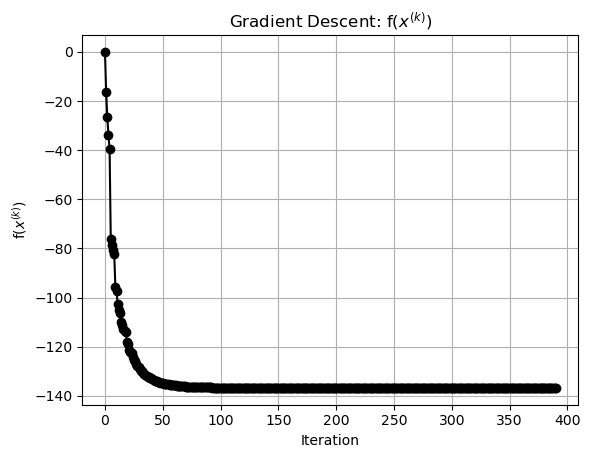

In [10]:
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

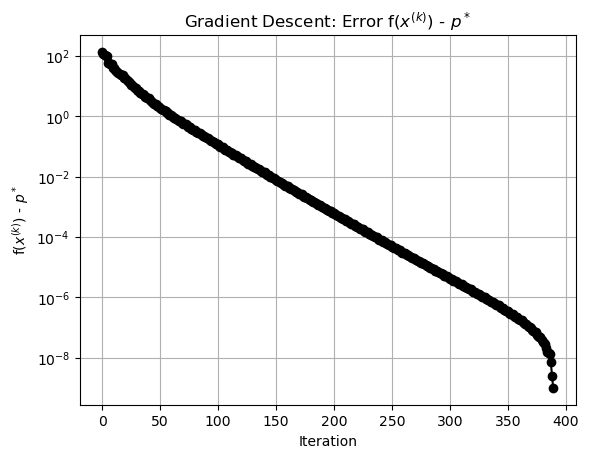

In [11]:
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


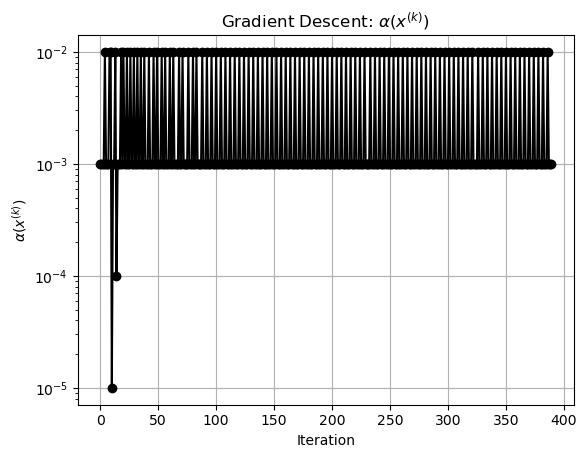

In [12]:
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()


### Experiment #2: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.5$ 

In [13]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [14]:
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = gradient_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 137.6036924927425
Iteration: 2, Current Function Value(Beginning of Iteration): -27.857861897445517, Norm of Gradient: 86.06321060059153
Iteration: 3, Current Function Value(Beginning of Iteration): -50.352651112941246, Norm of Gradient: 69.00511178888009
Iteration: 4, Current Function Value(Beginning of Iteration): -58.00686293918516, Norm of Gradient: 57.33605879827353
Iteration: 5, Current Function Value(Beginning of Iteration): -68.5291992812804, Norm of Gradient: 61.118333004720284
Iteration: 6, Current Function Value(Beginning of Iteration): -72.9651990217176, Norm of Gradient: 53.60028142349523
Iteration: 7, Current Function Value(Beginning of Iteration): -77.9864135976845, Norm of Gradient: 145.92020737861577
Iteration: 8, Current Function Value(Beginning of Iteration): -80.18137425587945, Norm of Gradient: 57.470498698093415
Iteration: 9, Current Function Value(Beginning of Iteration): -84.60

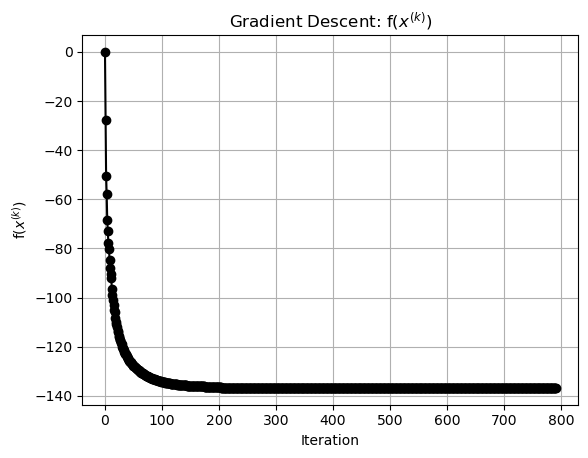

In [15]:
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

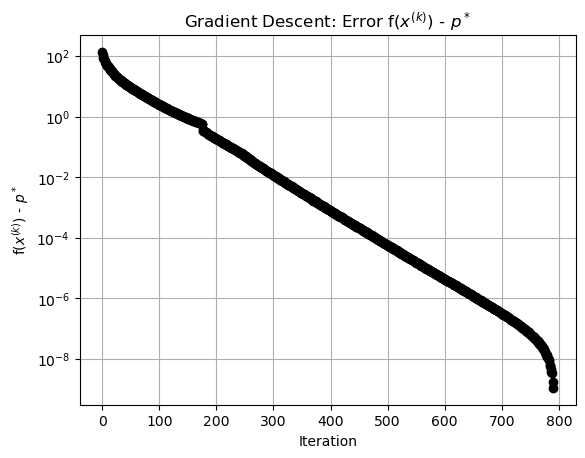

In [16]:
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

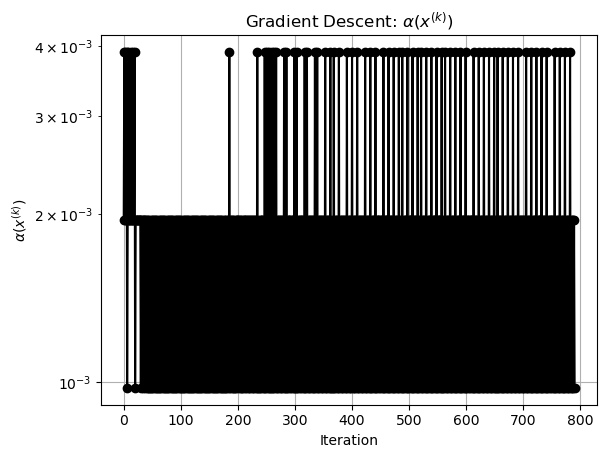

In [17]:
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #3: n = 100, m = 200, $\alpha = 0.15$, $\beta = 0.1$ 

In [18]:
#Global Variables
n = 100
m = 200
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [19]:
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = gradient_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 137.6036924927425
Iteration: 2, Current Function Value(Beginning of Iteration): -16.401208696404982, Norm of Gradient: 104.30434203439768
Iteration: 3, Current Function Value(Beginning of Iteration): -26.360557186578617, Norm of Gradient: 88.11261268218546
Iteration: 4, Current Function Value(Beginning of Iteration): -33.67914967216268, Norm of Gradient: 78.69176035506953
Iteration: 5, Current Function Value(Beginning of Iteration): -39.605297441701055, Norm of Gradient: 72.2137430560397
Iteration: 6, Current Function Value(Beginning of Iteration): -76.04749614087166, Norm of Gradient: 65.73861177812641
Iteration: 7, Current Function Value(Beginning of Iteration): -78.73201409279098, Norm of Gradient: 46.620188211622164
Iteration: 8, Current Function Value(Beginning of Iteration): -80.66392612020331, Norm of Gradient: 41.20471900791452
Iteration: 9, Current Function Value(Beginning of Iteration): -82.

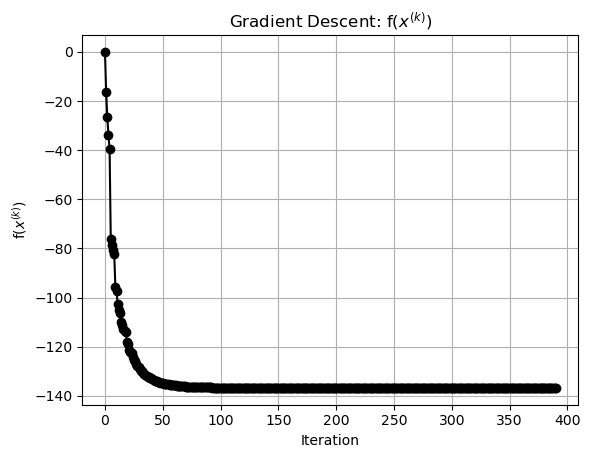

In [20]:
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

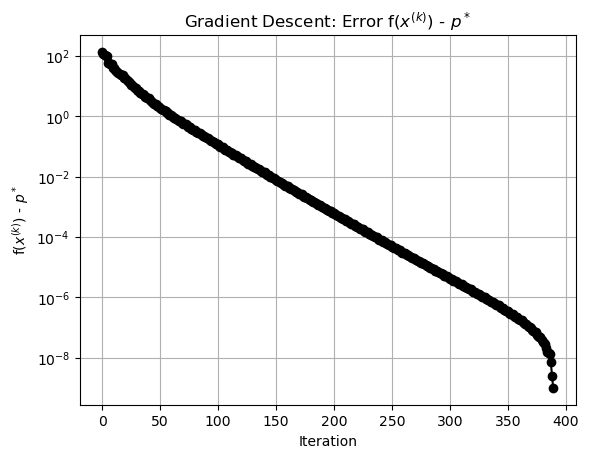

In [21]:
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

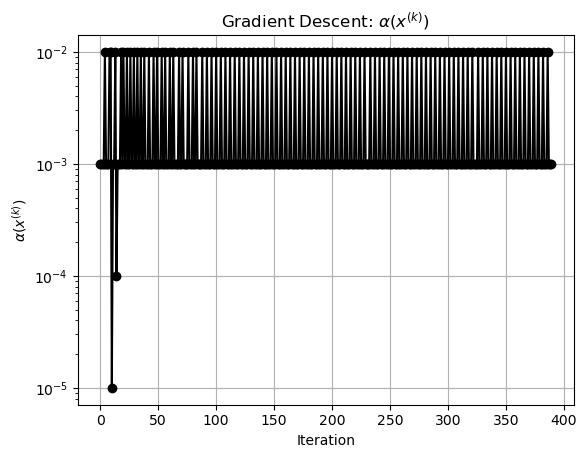

In [22]:
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #4: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.1$ 

In [23]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [24]:
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = gradient_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 304.478938803779
Iteration: 2, Current Function Value(Beginning of Iteration): -71.20599020028834, Norm of Gradient: 191.56350352398732
Iteration: 3, Current Function Value(Beginning of Iteration): -104.34300816643257, Norm of Gradient: 158.6501802743989
Iteration: 4, Current Function Value(Beginning of Iteration): -127.86061704934448, Norm of Gradient: 139.71286377218192
Iteration: 5, Current Function Value(Beginning of Iteration): -146.3988268117908, Norm of Gradient: 126.8870173433463
Iteration: 6, Current Function Value(Beginning of Iteration): -161.83564989947203, Norm of Gradient: 117.38103708472521
Iteration: 7, Current Function Value(Beginning of Iteration): -259.60722364596256, Norm of Gradient: 355.19998638466177
Iteration: 8, Current Function Value(Beginning of Iteration): -263.3781187420188, Norm of Gradient: 100.53618964692296
Iteration: 9, Current Function Value(Beginning of Iteration): 

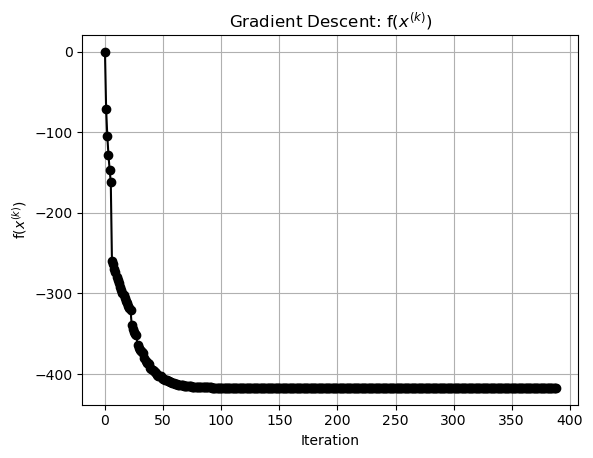

In [25]:
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

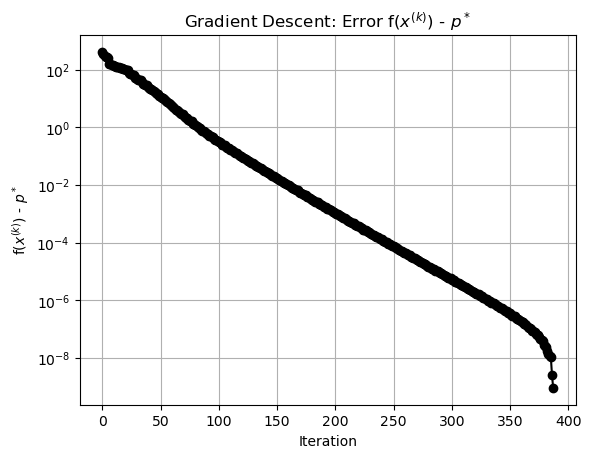

In [26]:
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

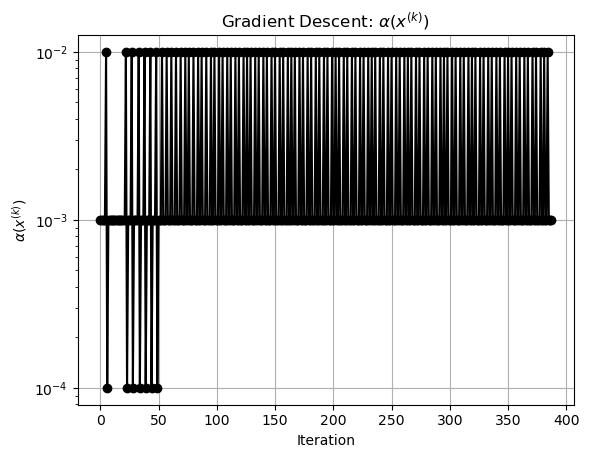

In [27]:
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #5: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.5$ 

In [28]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [29]:
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = gradient_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 304.478938803779
Iteration: 2, Current Function Value(Beginning of Iteration): -69.95854851541648, Norm of Gradient: 192.93003765823528
Iteration: 3, Current Function Value(Beginning of Iteration): -129.6191344066125, Norm of Gradient: 142.64983841200683
Iteration: 4, Current Function Value(Beginning of Iteration): -161.38186627033085, Norm of Gradient: 167.92186786959408
Iteration: 5, Current Function Value(Beginning of Iteration): -172.66760951222682, Norm of Gradient: 141.42057861814675
Iteration: 6, Current Function Value(Beginning of Iteration): -186.9742518029794, Norm of Gradient: 110.41631123212613
Iteration: 7, Current Function Value(Beginning of Iteration): -205.47558665331593, Norm of Gradient: 153.72671691491243
Iteration: 8, Current Function Value(Beginning of Iteration): -211.9597621496319, Norm of Gradient: 133.53472836077916
Iteration: 9, Current Function Value(Beginning of Iteration):

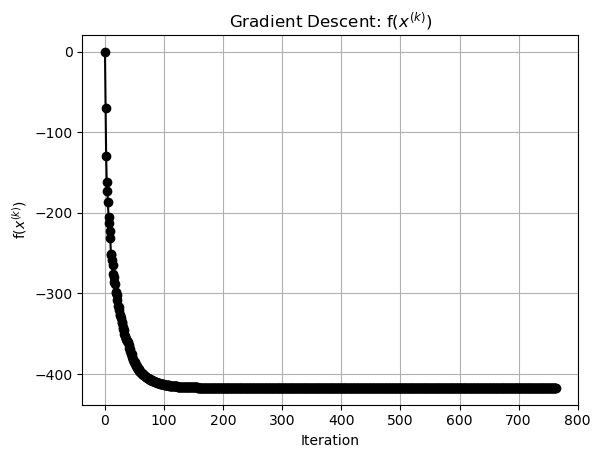

In [30]:
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

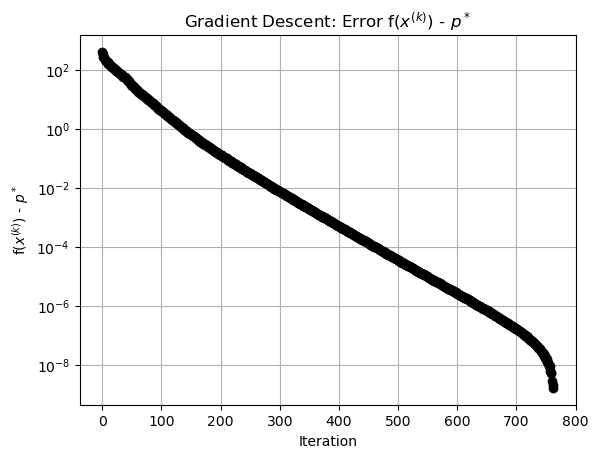

In [31]:
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

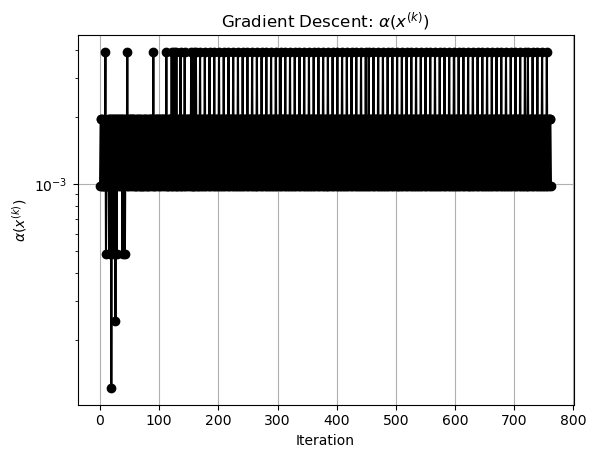

In [32]:
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #6: n = 200, m = 400, $\alpha = 0.15$, $\beta = 0.1$ 

In [33]:
#Global Variables
n = 200
m = 400
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [34]:
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = gradient_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 304.478938803779
Iteration: 2, Current Function Value(Beginning of Iteration): -71.20599020028834, Norm of Gradient: 191.56350352398732
Iteration: 3, Current Function Value(Beginning of Iteration): -104.34300816643257, Norm of Gradient: 158.6501802743989
Iteration: 4, Current Function Value(Beginning of Iteration): -127.86061704934448, Norm of Gradient: 139.71286377218192
Iteration: 5, Current Function Value(Beginning of Iteration): -146.3988268117908, Norm of Gradient: 126.8870173433463
Iteration: 6, Current Function Value(Beginning of Iteration): -161.83564989947203, Norm of Gradient: 117.38103708472521
Iteration: 7, Current Function Value(Beginning of Iteration): -259.60722364596256, Norm of Gradient: 355.19998638466177
Iteration: 8, Current Function Value(Beginning of Iteration): -263.3781187420188, Norm of Gradient: 100.53618964692296
Iteration: 9, Current Function Value(Beginning of Iteration): 

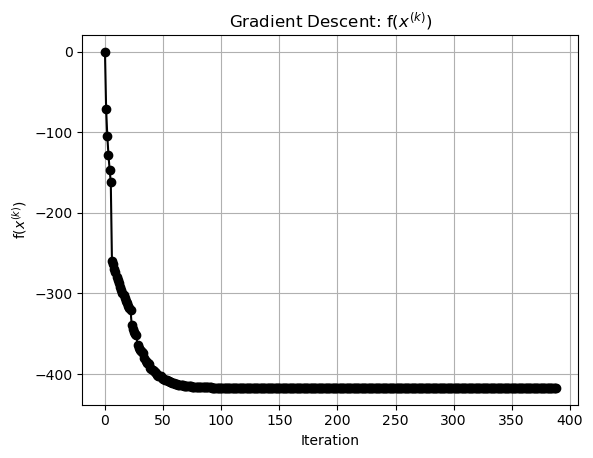

In [35]:
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

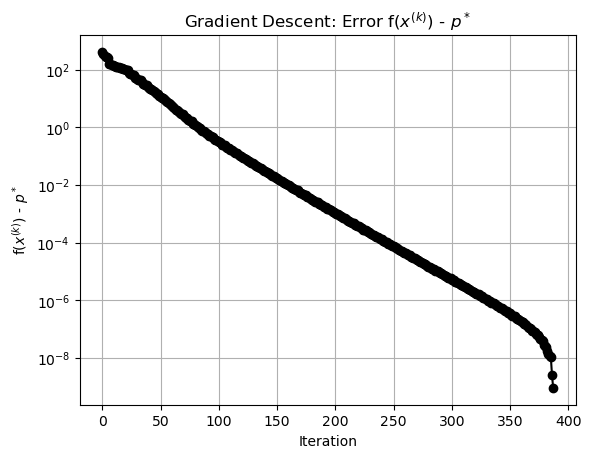

In [36]:
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

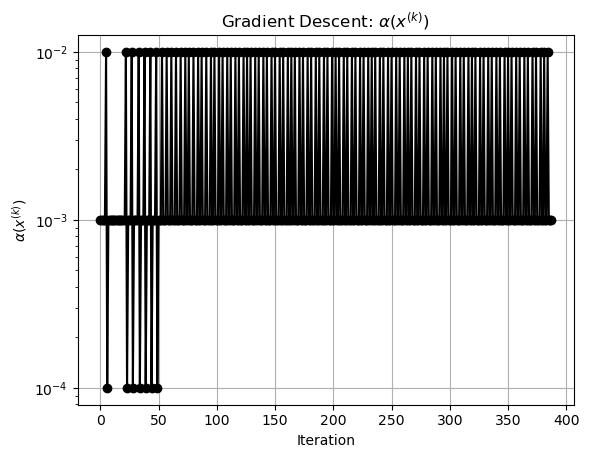

In [37]:
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

## 9.30 (b)

### Experiment #1: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.1$ 

In [38]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.1
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [39]:
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = newton_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Newton Parameter: 98.0074021411347
Iteration: 2, Current Function Value(Beginning of Iteration): -9.338422580529311, Newton Parameter: 96.33064843748771
Iteration: 3, Current Function Value(Beginning of Iteration): -18.516953219364165, Newton Parameter: 94.59876629002997
Iteration: 4, Current Function Value(Beginning of Iteration): -27.530355306949904, Newton Parameter: 92.80042359260483
Iteration: 5, Current Function Value(Beginning of Iteration): -88.13052296043873, Newton Parameter: 66.76100154739972
Iteration: 6, Current Function Value(Beginning of Iteration): -88.13052362804873, Newton Parameter: 66.76100109727842
Iteration: 7, Current Function Value(Beginning of Iteration): -129.24909237439329, Newton Parameter: 14.620375601551194
Iteration: 8, Current Function Value(Beginning of Iteration): -129.24909252059703, Newton Parameter: 14.620375337913922
Iteration: 9, Current Function Value(Beginning of Iteration): -13

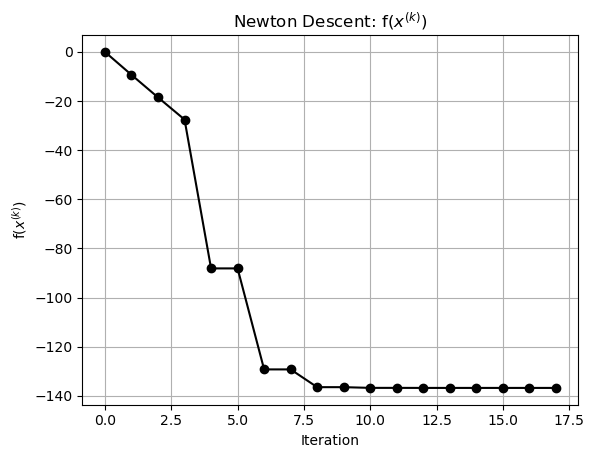

In [40]:
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


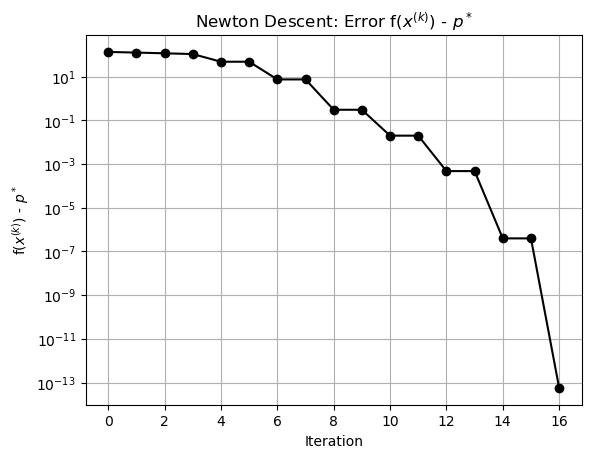

In [41]:
newton_descent_gap_to_optimal = newton_descent_function_values - p_star
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]


plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [42]:
newton_descent_alpha_values

array([1.e-01, 1.e-01, 1.e-01, 1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00,
       1.e-08, 1.e+00, 1.e-15, 1.e+00, 1.e-06, 1.e+00, 1.e-07, 1.e+00,
       1.e-01])

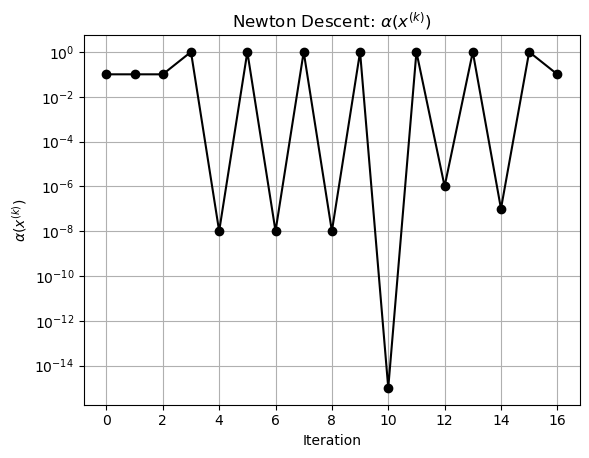

In [43]:
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()


### Experiment #2: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.5$ 

In [44]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [45]:
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = newton_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Newton Parameter: 98.0074021411347
Iteration: 2, Current Function Value(Beginning of Iteration): -39.30450628100764, Newton Parameter: 87.4365270697272
Iteration: 3, Current Function Value(Beginning of Iteration): -97.7442976350388, Newton Parameter: 58.42991520635436
Iteration: 4, Current Function Value(Beginning of Iteration): -97.7442980703756, Newton Parameter: 58.42991483809845
Iteration: 5, Current Function Value(Beginning of Iteration): -132.3189499211566, Newton Parameter: 8.934184789674966
Iteration: 6, Current Function Value(Beginning of Iteration): -132.31895018741605, Newton Parameter: 8.934184276782055
Iteration: 7, Current Function Value(Beginning of Iteration): -136.6736160436185, Newton Parameter: 0.21232147865683945
Iteration: 8, Current Function Value(Beginning of Iteration): -136.6736160942399, Newton Parameter: 0.2123213854137838
Iteration: 9, Current Function Value(Beginning of Iteration): -136.784

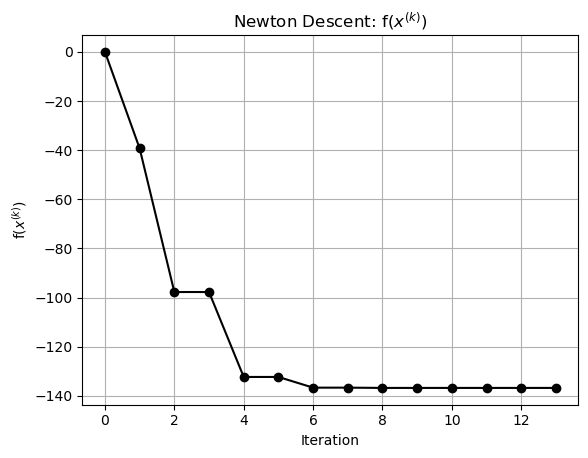

In [46]:
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


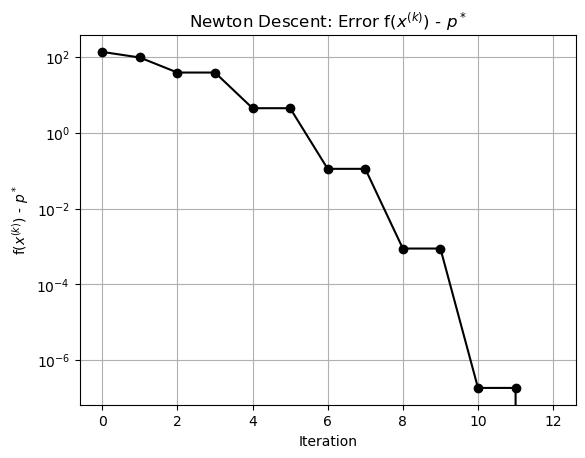

In [47]:
newton_descent_gap_to_optimal = newton_descent_function_values - p_star
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]


plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [48]:
newton_descent_alpha_values

array([5.00000000e-01, 1.00000000e+00, 7.45058060e-09, 1.00000000e+00,
       2.98023224e-08, 1.00000000e+00, 2.38418579e-07, 1.00000000e+00,
       1.90734863e-06, 1.00000000e+00, 6.10351562e-05, 1.00000000e+00,
       2.50000000e-01])

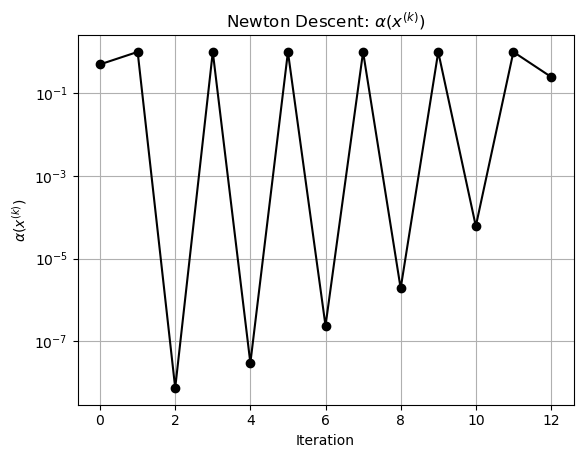

In [49]:
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #3: n = 100, m = 200, $\alpha = 0.15$, $\beta = 0.1$ 

In [50]:
#Global Variables
n = 100
m = 200
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [51]:
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = newton_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Newton Parameter: 98.0074021411347
Iteration: 2, Current Function Value(Beginning of Iteration): -9.338422580529311, Newton Parameter: 96.33064843748771
Iteration: 3, Current Function Value(Beginning of Iteration): -18.516953219364165, Newton Parameter: 94.59876629002997
Iteration: 4, Current Function Value(Beginning of Iteration): -27.530355306949904, Newton Parameter: 92.80042359260483
Iteration: 5, Current Function Value(Beginning of Iteration): -88.13052296043873, Newton Parameter: 66.76100154739972
Iteration: 6, Current Function Value(Beginning of Iteration): -88.13052362804873, Newton Parameter: 66.76100109727842
Iteration: 7, Current Function Value(Beginning of Iteration): -129.24909237439329, Newton Parameter: 14.620375601551194
Iteration: 8, Current Function Value(Beginning of Iteration): -129.24909252059703, Newton Parameter: 14.620375337913922
Iteration: 9, Current Function Value(Beginning of Iteration): -13

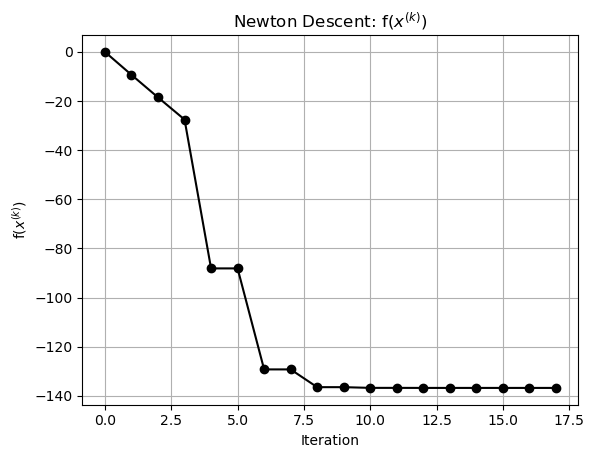

In [52]:
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


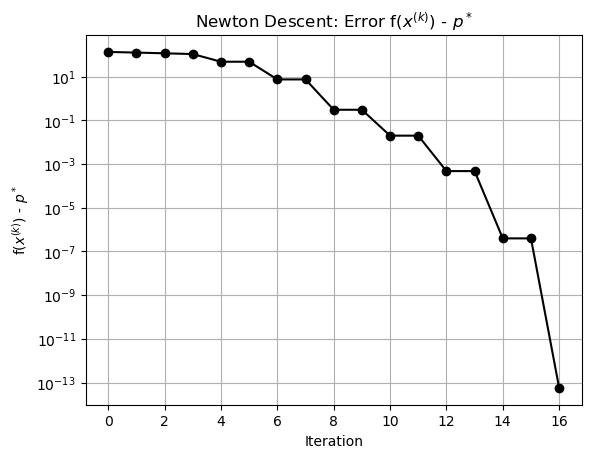

In [53]:
newton_descent_gap_to_optimal = newton_descent_function_values - p_star
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]


plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [54]:
newton_descent_alpha_values

array([1.e-01, 1.e-01, 1.e-01, 1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00,
       1.e-08, 1.e+00, 1.e-15, 1.e+00, 1.e-06, 1.e+00, 1.e-07, 1.e+00,
       1.e-01])

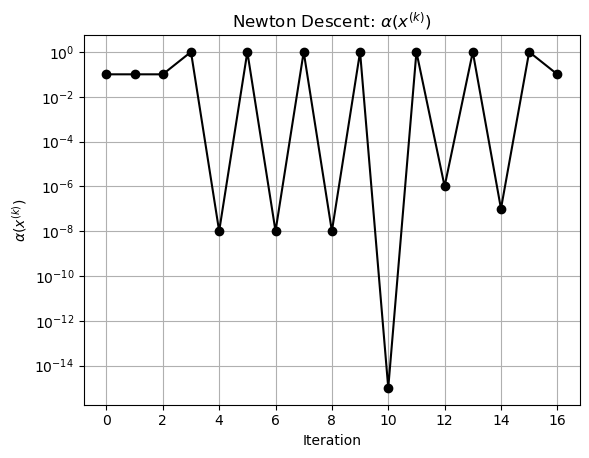

In [55]:
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #4: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.1$ 

In [56]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [57]:
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = newton_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Newton Parameter: 222.98514023977
Iteration: 2, Current Function Value(Beginning of Iteration): -153.18512063492332, Newton Parameter: 224.5552773301651
Iteration: 3, Current Function Value(Beginning of Iteration): -153.1851228804761, Newton Parameter: 224.55527742803287
Iteration: 4, Current Function Value(Beginning of Iteration): -306.8143487374977, Newton Parameter: 178.98034180942082
Iteration: 5, Current Function Value(Beginning of Iteration): -306.8143489164781, Newton Parameter: 178.98034166950433
Iteration: 6, Current Function Value(Beginning of Iteration): -323.8507658638182, Newton Parameter: 163.63491832124657
Iteration: 7, Current Function Value(Beginning of Iteration): -339.4203782895503, Newton Parameter: 145.7573884863005
Iteration: 8, Current Function Value(Beginning of Iteration): -353.2828591429491, Newton Parameter: 126.20151601834804
Iteration: 9, Current Function Value(Beginning of Iteration): -365

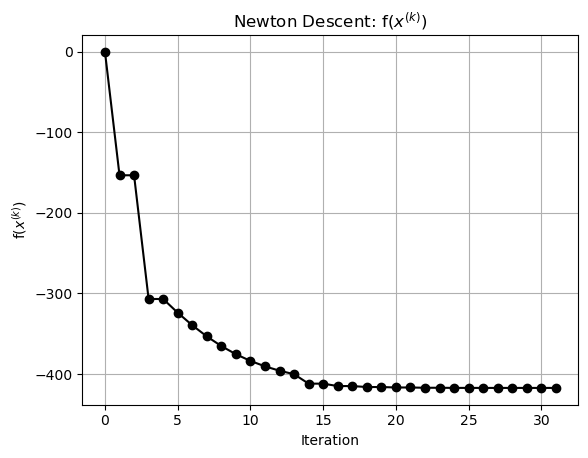

In [58]:
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


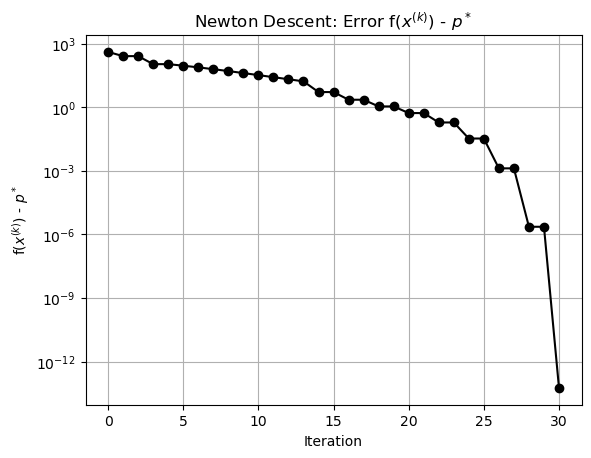

In [59]:
newton_descent_gap_to_optimal = newton_descent_function_values - p_star
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]


plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [60]:
newton_descent_alpha_values

array([1.e+00, 1.e-08, 1.e+00, 1.e-09, 1.e-01, 1.e-01, 1.e-01, 1.e-01,
       1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e-01, 1.e+00, 1.e-11, 1.e+00,
       1.e-07, 1.e+00, 1.e-08, 1.e+00, 1.e-07, 1.e+00, 1.e-07, 1.e+00,
       1.e-07, 1.e+00, 1.e-08, 1.e+00, 1.e-04, 1.e+00, 1.e-03])

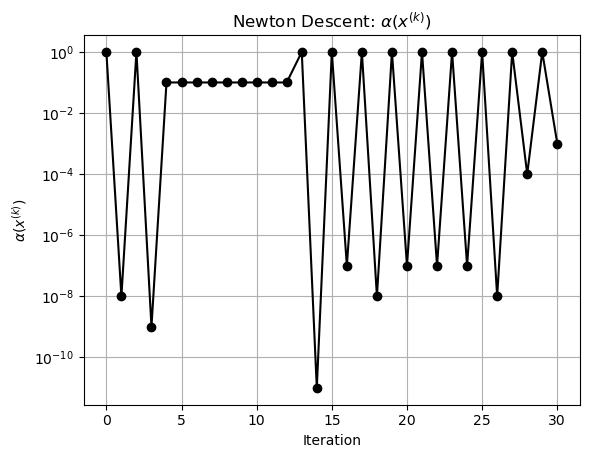

In [61]:
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #5: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.5$ 

In [62]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [63]:
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = newton_descent_function_values[-1]

Iteration: 1, Current Function Value(Beginning of Iteration): -0.0, Newton Parameter: 222.98514023977
Iteration: 2, Current Function Value(Beginning of Iteration): -153.18512063492332, Newton Parameter: 224.5552773301651
Iteration: 3, Current Function Value(Beginning of Iteration): -153.1851239810577, Newton Parameter: 224.55527747599936
Iteration: 4, Current Function Value(Beginning of Iteration): -306.8143498293491, Newton Parameter: 178.98034091963612
Iteration: 5, Current Function Value(Beginning of Iteration): -306.81435516337893, Newton Parameter: 178.98033674980672
Iteration: 6, Current Function Value(Beginning of Iteration): -376.72675782924705, Newton Parameter: 81.0124598421537
Iteration: 7, Current Function Value(Beginning of Iteration): -406.84298891037224, Newton Parameter: 20.903625180408223
Iteration: 8, Current Function Value(Beginning of Iteration): -414.67920261846933, Newton Parameter: 5.215978143873497
Iteration: 9, Current Function Value(Beginning of Iteration): -4

KeyboardInterrupt: 

In [ ]:
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


In [ ]:
newton_descent_gap_to_optimal = newton_descent_function_values - p_star
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]


plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [ ]:
newton_descent_alpha_values

In [ ]:
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #6: n = 200, m = 400, $\alpha = 0.15$, $\beta = 0.1$ 

In [ ]:
#Global Variables
n = 200
m = 400
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [ ]:
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = newton_descent_function_values[-1]

In [ ]:
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


In [ ]:
newton_descent_gap_to_optimal = newton_descent_function_values - p_star
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]


plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [ ]:
newton_descent_alpha_values

In [ ]:
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

## 9.31 (a)

### Experiment #1

In [ ]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [ ]:
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_alpha_values_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)
p_star_N1 = reused_newton_descent_function_values_N1[-1]

In [ ]:
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_alpha_values_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)
p_star_N2 = reused_newton_descent_function_values_N2[-1]

In [ ]:
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_alpha_values_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)
p_star_N5 = reused_newton_descent_function_values_N5[-1]

In [ ]:
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_N1
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_N2
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_N5

reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_gap_to_optimal_N1[:-1]
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_gap_to_optimal_N2[:-1]
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_gap_to_optimal_N5[:-1]

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3], labels=['Newton\'s Method', 'N = 2', 'N = 5'])
plt.grid(True)
plt.show()

### Experiment #2

In [ ]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [ ]:
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_alpha_values_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)
p_star_N1 = reused_newton_descent_function_values_N1[-1]

In [ ]:
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_alpha_values_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)
p_star_N2 = reused_newton_descent_function_values_N2[-1]

In [ ]:
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_alpha_values_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)
p_star_N5 = reused_newton_descent_function_values_N5[-1]

In [ ]:
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_N1
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_N2
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_N5

reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_gap_to_optimal_N1[:-1]
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_gap_to_optimal_N2[:-1]
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_gap_to_optimal_N5[:-1]

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3], labels=['Newton\'s Method', 'N = 2', 'N = 5'])
plt.grid(True)
plt.show()

## 9.31 (b)

### Experiment #1

In [ ]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(42)
A = np.random.normal(size = (m, n))

In [ ]:
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_alpha_values = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = diagonal_newton_descent_function_values[-1]

In [ ]:
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

In [ ]:
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

### Experiment #2

In [ ]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(32)
A = np.random.normal(size = (m, n))

In [ ]:
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_alpha_values = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star = diagonal_newton_descent_function_values[-1]

In [ ]:
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

In [ ]:
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()